In [0]:
##imports 

#basic imports 
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

#models 
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

#cluster eval
from sklearn.metrics import silhouette_score 
from sklearn import metrics 

In [2]:
#read in data
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv') 
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [4]:
df.isnull().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

In [5]:
#we'll drop categorical variables as they aren't useful in K means clustering 
df.drop(['ctz','name','bib','state','country','city','gender'],axis=1,inplace=True)
df.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72


In [6]:
df.iloc[3189]

10k               -
division        647
25k               -
age              47
official     195.82
genderdiv      4815
35k          160.48
overall        5463
pace           7.48
30k               -
5k                -
half              -
20k               -
40k          184.62
Name: 3189, dtype: object

In [0]:
#convert splits to float value, replacing '-' in splits 
splits = ['10k','25k','35k','30k','5k','half','20k','40k']
for col in splits:
    df[col] = df[col].str.replace('-','')
    df[col] = pd.to_numeric(df[col])

In [0]:
#drop the null split values 
df = df.dropna()

In [9]:
df.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,1922.747291,133.581175,42.385067,241.952383,8002.921988,196.033373,15833.958924,9.236463,163.894883,25.678261,111.211481,105.321404,228.189990
std,8.710102,1704.843679,25.571480,11.299795,50.842552,4733.255987,40.775036,9182.223743,1.939150,32.889354,4.215381,20.306387,19.159500,48.074493
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.370000,607.000000,115.430000,33.000000,205.300000,3940.000000,166.950000,7880.000000,7.830000,140.520000,22.620000,96.750000,91.670000,193.620000
50%,50.280000,1418.000000,128.850000,42.000000,231.980000,7919.000000,187.850000,15829.000000,8.850000,157.500000,25.050000,107.680000,102.000000,218.470000
75%,57.000000,2601.000000,147.700000,50.000000,272.200000,11893.000000,219.370000,23785.000000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


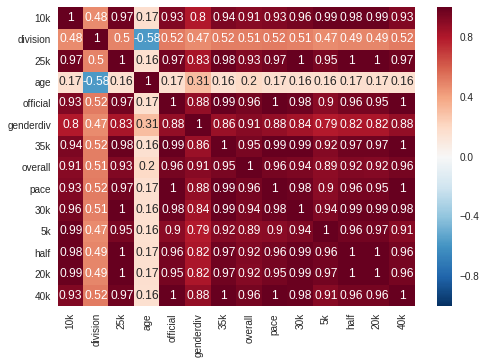

In [10]:
corr = df.corr()
sns.heatmap(corr,annot=True)

In [11]:
X = df
#address heavy correlation with PCA 
X_norm = normalize(X)
print(len(X_norm))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
# Initialize data frames
ypred = pd.DataFrame()

31649


In [0]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

In [13]:
# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

7912 7912
7912 7912
7912 7912
7913 7913


In [0]:
# Ensuring all sets are the same length
X4 = X4[:7912][:]
X_pca4 = X_pca4[:7912][:]

In [15]:
# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

7912 7912
7912 7912
7912 7912
7912 7912


## K-Means 

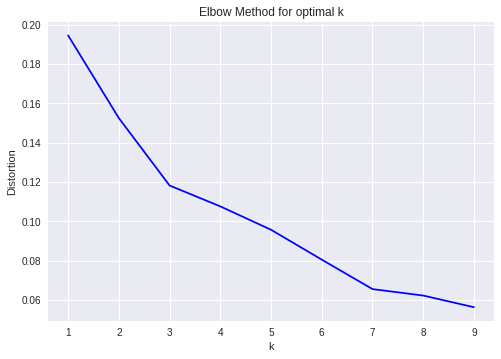

In [18]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_norm)
    kmeanModel.fit(X_norm)
    distortions.append(sum(np.min(cdist(X_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_norm.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

In [0]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

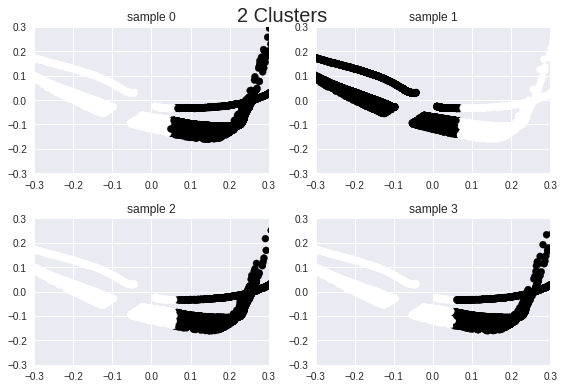

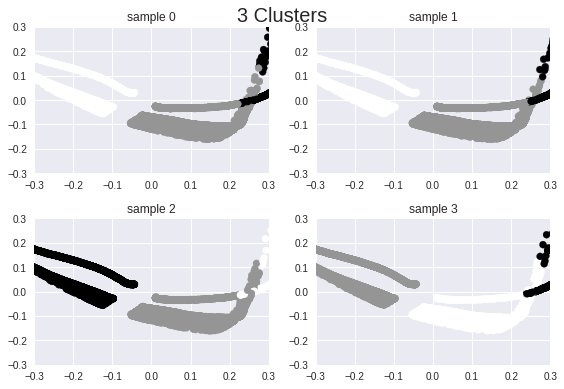

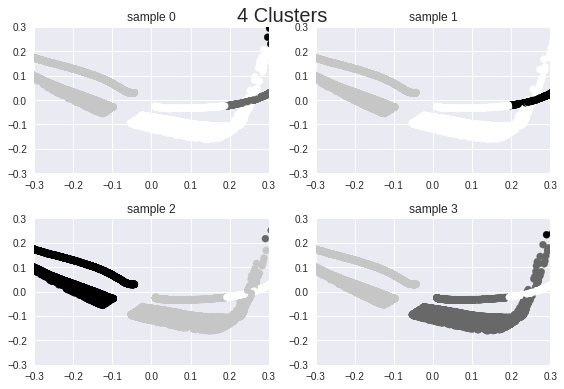

In [20]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [21]:
#we'll use silhouette for evaluating considering we don't have a label or ground truth for the ARI 
for n_cluster in range(2, 6):
   for sample in [X1, X2, X3, X4]:
    kmeans = KMeans(n_clusters=n_cluster).fit(sample)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(sample, labels, metric='euclidean')
    print("For {} clusters, our Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For 2 clusters, our Silhouette Coefficient is 0.45212140855707433
For 2 clusters, our Silhouette Coefficient is 0.46181271891810144
For 2 clusters, our Silhouette Coefficient is 0.45096523649802156
For 2 clusters, our Silhouette Coefficient is 0.44613226775869574
For 3 clusters, our Silhouette Coefficient is 0.48015893254623465
For 3 clusters, our Silhouette Coefficient is 0.4717386219737289
For 3 clusters, our Silhouette Coefficient is 0.4784019424231596
For 3 clusters, our Silhouette Coefficient is 0.481397458555755
For 4 clusters, our Silhouette Coefficient is 0.4943385355778417
For 4 clusters, our Silhouette Coefficient is 0.49263350647447085
For 4 clusters, our Silhouette Coefficient is 0.49504070284245016
For 4 clusters, our Silhouette Coefficient is 0.4985138504438221
For 5 clusters, our Silhouette Coefficient is 0.4428230878807168
For 5 clusters, our Silhouette Coefficient is 0.39719434249114316
For 5 clusters, our Silhouette Coefficient is 0.3963247273209103
For 5 clusters, ou

Looks like the best cluster here is 4 showcased both from the  Silhouette score and 2 from the Elbow method 

## Mean Shift

In [34]:
for counter, data in enumerate([X1, X2, X3, X4]): 
    # Generate cluster predictions
    for n in [0.1, 0.2, 0.3, 0.4]:
      bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
      ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
      ms.fit(X_norm)   
      labels = ms.labels_
      cluster_centers = ms.cluster_centers_
      n_clusters_ = len(np.unique(labels))  
      sil_coeff = silhouette_score(X_norm,labels,metric='euclidean')
      print("For {} clusters, our Silhouette Coefficient is {}".format(n_clusters_, sil_coeff))

For 10 clusters, our Silhouette Coefficient is 0.46685240023091157
For 4 clusters, our Silhouette Coefficient is 0.5245924575587575
For 5 clusters, our Silhouette Coefficient is 0.5076460210513232
For 4 clusters, our Silhouette Coefficient is 0.5020224319839586
For 11 clusters, our Silhouette Coefficient is 0.4635051963945374
For 4 clusters, our Silhouette Coefficient is 0.5245924575587575
For 5 clusters, our Silhouette Coefficient is 0.508538023682187
For 5 clusters, our Silhouette Coefficient is 0.5005294242226063
For 11 clusters, our Silhouette Coefficient is 0.46423354040557036
For 4 clusters, our Silhouette Coefficient is 0.52376937676895
For 5 clusters, our Silhouette Coefficient is 0.5082500649970662
For 4 clusters, our Silhouette Coefficient is 0.5023539823018154
For 11 clusters, our Silhouette Coefficient is 0.46400680488754104
For 4 clusters, our Silhouette Coefficient is 0.5246449949308497
For 4 clusters, our Silhouette Coefficient is 0.5120293351505008
For 4 clusters, our S

It seems that quantile .4 had the most consistently high silhouette score with 4 clusters on samples 2-4 and 11 clusters for sample 1. 

## Spectral Clustering

In [0]:
# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
      pred = SpectralClustering(n_clusters=nclust, random_state=42).fit_predict(data[0])
      ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

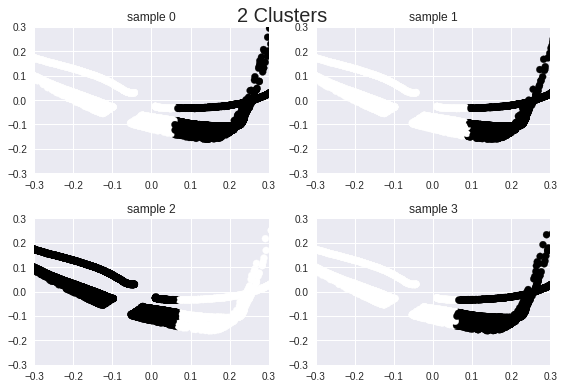

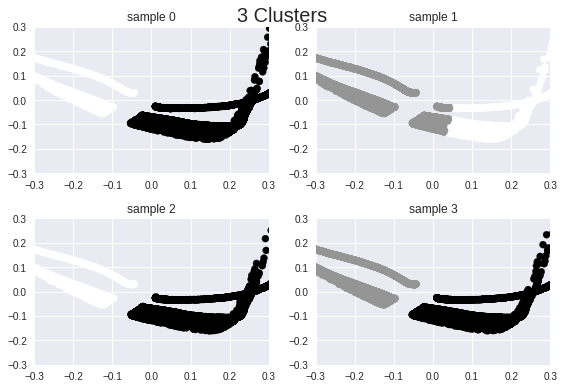

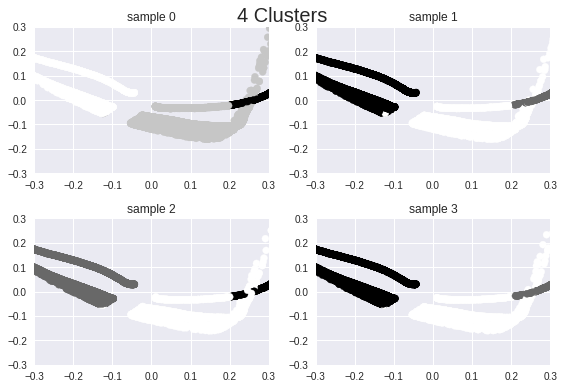

In [18]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [19]:
#we'll use silhouette for evaluating considering we don't have a label or ground truth for the ARI 
for n_cluster in range(2, 6):
   for sample in [X1, X2, X3, X4]:
    sc = SpectralClustering(n_clusters=n_cluster).fit(sample)
    labels = sc.labels_
    sil_coeff = silhouette_score(sample, labels, metric='euclidean')
    print("For {} clusters, our Silhouette Coefficient is {}".format(n_cluster, sil_coeff))   

For 2 clusters, our Silhouette Coefficient is 0.4562955532819751
For 2 clusters, our Silhouette Coefficient is 0.4741494252966449
For 2 clusters, our Silhouette Coefficient is 0.45582626425497685
For 2 clusters, our Silhouette Coefficient is 0.45091683868325694
For 3 clusters, our Silhouette Coefficient is 0.42522527105427477
For 3 clusters, our Silhouette Coefficient is 0.44837413056720177
For 3 clusters, our Silhouette Coefficient is 0.4200280530987593
For 3 clusters, our Silhouette Coefficient is 0.4260675617450715
For 4 clusters, our Silhouette Coefficient is 0.4887432868274685
For 4 clusters, our Silhouette Coefficient is 0.4864498968570765
For 4 clusters, our Silhouette Coefficient is 0.48946160477556266
For 4 clusters, our Silhouette Coefficient is 0.49297919406058366
For 5 clusters, our Silhouette Coefficient is 0.4940623142425925
For 5 clusters, our Silhouette Coefficient is 0.4910596304007437
For 5 clusters, our Silhouette Coefficient is 0.493495934507231
For 5 clusters, our 

Looks like the best scores in Spectral Clustering came from 5 clusters with 4 following close afterwards.

## Affinity Propagation

In [21]:
for counter, data in enumerate([X1, X2, X3, X4]): 
  af = AffinityPropagation().fit(data)
  # Pull the number of clusters and cluster assignments for each data point.
  cluster_centers_indices = af.cluster_centers_indices_
  n_clusters_ = len(cluster_centers_indices)
  labels = af.labels_
  sil_coeff = silhouette_score(data, labels, metric='euclidean')
  print("For {} clusters, our Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For 5 clusters, our Silhouette Coefficient is 0.15424933921970627
For 5 clusters, our Silhouette Coefficient is 0.10518306039321992
For 5 clusters, our Silhouette Coefficient is 0.06602487188229902
For 5 clusters, our Silhouette Coefficient is 0.15345737943948107


Seems as though this model chose 5 clusters, though had a very low silhouette score.

## Conclusion 

All in all, it appears with each model the highest silhouette scores come out of 4-5 clustering groups, telling us that, withn the boston marathon in 2014, there was around 4-5 groups of runners. Our best model performance was between our Kmeans and Mean Shift model, with Affinity Propagation coming in last. 